# Variational Autoencoders #
## Abstract ##

In this part, I use Variational Autoencoders to generate fake images. And I aslo adjust the size of the latent space and change the network architecture to figure out the best combination of them to generate most realistic images.

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as K

In [3]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [4]:
latent_dim = 2 # because of z_mean and z_log_variance
encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
conv_shape = K.int_shape(x) #Shape of conv to be provided to decoder
print(conv_shape)
x = layers.Flatten()(x)
x = layers.Dense(32, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

(None, 7, 7, 64)
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 64)     18496       conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 3136)         0           conv2d_1[0][0]                   
___________________________________________________________________________

In [5]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(conv_shape[1] * conv_shape[2] * conv_shape[3], activation="relu")(latent_inputs) # 7x7x64 shape
x = layers.Reshape((conv_shape[1],conv_shape[2], conv_shape[3]))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_______________________________________________________

In [6]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [7]:
import pandas as pd
df = pd.read_csv('./data/94_character_TMNIST.csv')

In [8]:
print(df.shape)
X = df.drop(columns={'names','labels'})

(274093, 786)


In [9]:
X_images = X.values.reshape(-1,28,28)
X_images = np.expand_dims(X_images, -1).astype("float32") / 255

In [10]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(X_images, epochs=10, batch_size=128)

Epoch 1/10
2142/2142 [==============================] - 425s 195ms/step - loss: 208.4493 - reconstruction_loss: 181.7621 - kl_loss: 3.6018
Epoch 2/10
2142/2142 [==============================] - 330s 154ms/step - loss: 164.2448 - reconstruction_loss: 156.7019 - kl_loss: 5.8207
Epoch 3/10
2142/2142 [==============================] - 371s 173ms/step - loss: 158.7653 - reconstruction_loss: 151.9908 - kl_loss: 5.9395
Epoch 4/10
2142/2142 [==============================] - 497s 232ms/step - loss: 156.0738 - reconstruction_loss: 149.6133 - kl_loss: 5.9907
Epoch 5/10
2142/2142 [==============================] - 487s 227ms/step - loss: 154.5192 - reconstruction_loss: 147.9891 - kl_loss: 6.0477
Epoch 6/10
2142/2142 [==============================] - 562s 262ms/step - loss: 153.1298 - reconstruction_loss: 146.7858 - kl_loss: 6.0972
Epoch 7/10
2142/2142 [==============================] - 487s 228ms/step - loss: 152.3490 - reconstruction_loss: 145.8358 - kl_loss: 6.1409
Epoch 8/10
2142/2142 [=====

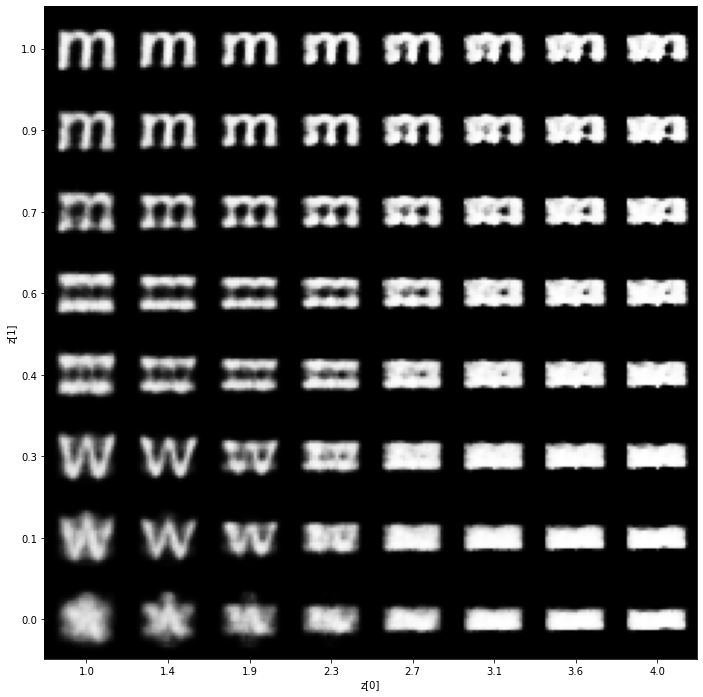

In [12]:
import matplotlib.pyplot as plt

def plot_latent_space(vae, n=8, figsize=12):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale_x_left = 1 # If we change the range, t generate different image.  
    scale_x_right = 4
    scale_y_bottom = 0
    scale_y_top = 1
    figure = np.zeros((digit_size * n, digit_size * n))
    # If we want to see different x and y range we can change values in grid_x and gird_y. I trid x= [-3,-2] and y = [-3,-1] values and m labeled imaged are generated.
    grid_x = np.linspace(scale_x_left, scale_x_right, n)        # -3, -2
    grid_y = np.linspace(scale_y_bottom, scale_y_top, n)[::-1]  # -3, -1 

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

plot_latent_space(vae)


## Conclusion ##
For Variational Autoencoders, I use latent_dim = 2 and epcho = 10 to generate images. The result of this experiments show that this architecture generate really good fake images.